# Инициализация

Загружаем библиотеки необходимые для выполнения кода ноутбука.

In [1]:
# Standard library imports
import calendar
import gc

# Third-party library imports
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from catboost import CatBoostClassifier, Pool
from implicit.als import AlternatingLeastSquares
from sklearn.preprocessing import LabelEncoder

# Setting constants
RANDOM_STATE = 42

# Tweaking additional settings
sns.set_theme()

/home/mle-user/mle_projects/final_projects/mle-project-sprint-4-v001/.venv_recsys/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# === ЭТАП 1 ===

# Загрузка первичных данных

Перед загрузкой данных необходимо вначале загрузить данные при помощи команды `wget` как указано в файле `README.md`. Следующие первичные данные были заранее скачаны и перемещены в папку `data`:
- `tracks.parquet`
- `catalog_names.parquet`
- `interactions.parquet`

В случае отсутствия данных в папке `data`, файлы будут искаться и в текущей директории, в связи с чем код загрузки данных следующий:

In [2]:
%%time
try:
    tracks = pd.read_parquet("data/tracks.parquet")
    catalog_names = pd.read_parquet("data/catalog_names.parquet")
    events = pd.read_parquet("data/interactions.parquet")
except FileNotFoundError:
    tracks = pd.read_parquet("tracks.parquet")
    catalog_names = pd.read_parquet("catalog_names.parquet")
    events = pd.read_parquet("interactions.parquet")

CPU times: user 9.23 s, sys: 11.1 s, total: 20.3 s
Wall time: 31.3 s


Подобная схема будет использоваться в дальнейшем при загрузке и сохранении данных.

# Обзор данных

Теперь когда данные загружены, проверим их на предмет наличия явных проблем. Проанализируем каждый из созданных на предыдущем этапе датафреймов:

* `tracks`
* `catalog_names`
* `events`

## Tracks

Для начала рассмотрим данные о музыкальных треках из `tracks`:

In [3]:
tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 4 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   track_id  1000000 non-null  int64 
 1   albums    1000000 non-null  object
 2   artists   1000000 non-null  object
 3   genres    1000000 non-null  object
dtypes: int64(1), object(3)
memory usage: 30.5+ MB


Вывод общей информации о музыкальных треках показывает, что в данных присутствует информация о 1 млн объектов с информацией о альбоме, в котором конкретный трек присутствует, исполнителе и жанре. 

Проверим, точно ли каждая строка датафрейма однозначно определена (то есть нет дубликатов идентификаторов треков):

In [4]:
assert tracks.track_id.duplicated().sum() == 0

Все в норме, у нас есть данные о 1 млн уникальных музыкальных треков. Посмотрим, как выглядит датафрейм, вывев первые 5 строк:

In [5]:
tracks.head()

,track_id,albums,artists,genres
0,26,"[3, 2490753]",[16],"[11, 21]"
1,38,"[3, 2490753]",[16],"[11, 21]"
2,135,"[12, 214, 2490809]",[84],[11]
3,136,"[12, 214, 2490809]",[84],[11]
4,138,"[12, 214, 322, 72275, 72292, 91199, 213505, 24...",[84],[11]


Здесь как раз и вырисовывается первая проблема: будет проблематично работать с такими списками как значениями датафрейма. Дело даже не только в том, что такой формат данных непригоден для дальнейшего построения рекомендательной системы, но и ввиду того, что даже пустой список будет являться значением, то есть следующий код ожидаемо не найдет пропущенных значений:

In [6]:
tracks.isna().sum()

track_id    0
albums      0
artists     0
genres      0
dtype: int64

Итак, нам необходимо придумать способ, как нам разъединить эти списки. К счастью, метод `explode` библиотеки `pandas` занимается как раз таки этим. Поскольку в каждой из колонок, содержащих списки, размеры списков разные, придется последовательно применить данной метод к каждой из таких колонок следующим образом:

In [7]:
%%time
tracks = tracks \
            .explode(column=["albums"], ignore_index=True) \
            .explode(column=["artists"], ignore_index=True) \
            .explode(column=["genres"], ignore_index=True)

tracks.head()

CPU times: user 8.26 s, sys: 973 ms, total: 9.23 s
Wall time: 9.23 s


,track_id,albums,artists,genres
0,26,3,16,11
1,26,3,16,21
2,26,2490753,16,11
3,26,2490753,16,21
4,38,3,16,11


Мы видим теперь, что у нас нет больше списков, поскольку мы раздробили значения в списках по `track_id`. В результате размер датафрейма увеличился, ведь теперь у нас списки разбились по идентификатору трека. Теперь конечно мы уже сможем понять, где есть пропуски:

In [8]:
tracks.isna().sum()

track_id        0
albums         18
artists     41789
genres      36675
dtype: int64

In [9]:
tracks.isna().sum() / tracks.shape[0]

track_id    0.000000
albums      0.000003
artists     0.006177
genres      0.005421
dtype: float64

Видим, что у нас все-таки присутствуют в данных треки с неизвестными альбомами, исполнителями и жанрами. Более подробно такие треки будут рассмотрены позже. Сейчас же для удобства переименуем колонки, ведь у нас здесь именно идентификаторы:

In [10]:
tracks = tracks.rename(
    columns= {
        "albums": "album_id",
        "artists": "artist_id",
        "genres": "genre_id",
    }
)

tracks.head(3)

,track_id,album_id,artist_id,genre_id
0,26,3,16,11
1,26,3,16,21
2,26,2490753,16,11


## Catalogue

Теперь рассмотрим датафрейм `catalog_names`:

In [11]:
catalog_names.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1812471 entries, 0 to 1812470
Data columns (total 3 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   id      int64 
 1   type    object
 2   name    object
dtypes: int64(1), object(2)
memory usage: 41.5+ MB


In [12]:
catalog_names.head()

,id,type,name
0,3,album,Taller Children
1,12,album,Wild Young Hearts
2,13,album,Lonesome Crow
3,17,album,Graffiti Soul
4,26,album,Blues Six Pack


In [13]:
catalog_names.isna().sum()

id      0
type    0
name    0
dtype: int64

In [14]:
catalog_names.type.value_counts()

type
track     1000000
album      658724
artist     153581
genre         166
Name: count, dtype: int64

Видим, что буквально в один датафрейм забили данные о названиях треков, альбомов, исполнителей и жанров. В таком виде это крайне неудобно, так что одним из решений может быть разбить датафрейм на несколько суб-датафреймов:

* `genres` => Данные о жанрах
* `track_names` => Данные о названиях треков
* `albums` => Данные о названиях альбомов
* `artists` => Данные о исполнителях

In [15]:
genres = catalog_names \
            .query("type == 'genre'") \
            .drop("type", axis=1) \
            .rename(
                columns={
                    "id": "genre_id",
                    "name": "genre"
                }
            )

genres.head(3)

,genre_id,genre
812305,0,all
812306,1,eastern
812307,2,rusrock


In [16]:
track_names = catalog_names \
            .query("type == 'track'") \
            .drop("type", axis=1) \
            .rename(
                columns={
                    "id": "track_id",
                    "name": "track"
                }
            )

track_names.head(3)

,track_id,track
812471,26,Complimentary Me
812472,38,Momma's Boy
812473,135,Atticus


In [17]:
albums = catalog_names \
            .query("type == 'album'") \
            .drop("type", axis=1) \
            .rename(
                columns={
                    "id": "album_id",
                    "name": "album"
                }
            )

albums.head(3)

,album_id,album
0,3,Taller Children
1,12,Wild Young Hearts
2,13,Lonesome Crow


In [18]:
artists = catalog_names \
            .query("type == 'artist'") \
            .drop("type", axis=1) \
            .rename(
                columns={
                    "id": "artist_id",
                    "name": "artist"
                }
            )

artists.head(3)

,artist_id,artist
658724,4,Kenny Dorham
658725,5,Max Roach
658726,7,Francis Rossi


## Items

Теперь когда у нас есть отдельные датафреймы, мы можем их смержить по их соответствующим идентификаторам с датафреймом `tracks` для того чтобы получить более ясную информацию о треках:

In [19]:
%%time
items = tracks \
            .merge(track_names, on="track_id", how="left") \
            .merge(albums, on="album_id", how="left") \
            .merge(artists, on="artist_id", how="left") \
            .merge(genres, on="genre_id", how="left")

CPU times: user 9.34 s, sys: 3.63 s, total: 13 s
Wall time: 13 s


Оставим информацию только о идентификаторе трека и строчной информации о них:

In [20]:
items = items[["track_id", "track", "artist", "album", "genre"]]
items.head()

,track_id,track,artist,album,genre
0,26,Complimentary Me,Elizabeth & the Catapult,Taller Children,pop
1,26,Complimentary Me,Elizabeth & the Catapult,Taller Children,folk
2,26,Complimentary Me,Elizabeth & the Catapult,Taller Children,pop
3,26,Complimentary Me,Elizabeth & the Catapult,Taller Children,folk
4,38,Momma's Boy,Elizabeth & the Catapult,Taller Children,pop


Чтобы было возможно однозначно идентифицировать трек, необходимо избавиться от неявных дубликатов и оставить только один. Можно в данном случае выбрать треки многими способами, но для удобства здесь в качестве решения выберем только первый идентификатор трека из дубликатов трека:

In [21]:
items = items.groupby("track_id").head(1)
items.head()

,track_id,track,artist,album,genre
0,26,Complimentary Me,Elizabeth & the Catapult,Taller Children,pop
4,38,Momma's Boy,Elizabeth & the Catapult,Taller Children,pop
8,135,Atticus,Noisettes,Wild Young Hearts,pop
11,136,24 Hours,Noisettes,Wild Young Hearts,pop
14,138,Don't Upset The Rhythm (Go Baby Go),Noisettes,Wild Young Hearts,pop


In [22]:
assert items.track_id.duplicated().sum() == 0

In [23]:
items.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Index: 1000000 entries, 0 to 6765309
Data columns (total 5 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   track_id  1000000 non-null  int64 
 1   track     1000000 non-null  object
 2   artist    984631 non-null   object
 3   album     999982 non-null   object
 4   genre     996306 non-null   object
dtypes: int64(1), object(4)
memory usage: 311.1 MB


In [24]:
items.isna().sum()

track_id        0
track           0
artist      15369
album          18
genre        3694
dtype: int64

Теперь мы можем рассмотреть треки с неизвестными исполнителями, альбомами и жанрами.

### Неизвестные альбомы

Видим, что у нас в данных (после мержа и после удаления дубликатов) все же остались треки, у которых отсутствуют названия исполнителей, альбома и жанров. Взглянем сначала на неизвестные альбомы:

In [25]:
items[(items.album.isna() == True)]

,track_id,track,artist,album,genre
2730910,20200372,На скотч,NaN,NaN,NaN
2730923,20200380,Yo Te Quiero (Я тебя люблю),NaN,NaN,NaN
2739901,20305116,Мой путь,NaN,NaN,NaN
2739914,20305121,Вечность,NaN,NaN,NaN
2837815,20756854,Виновата,NaN,NaN,NaN
2879025,21196099,Are You with Me,NaN,NaN,NaN
2879037,21196103,Historia de Amor,NaN,NaN,NaN
2879042,21196105,Stronger Than Ever,NaN,NaN,NaN
2879051,21196107,Here We Go,NaN,NaN,NaN
2879058,21196109,Long Story Short,NaN,NaN,NaN


### Неизвестные исполнители

Теперь посмотрим на неизвестных исполнителей, где заметим, что в основном это касается треков-подкастов:

In [26]:
unknown_artists = items[(items.artist.isna() == True)]
unknown_artists.sample(10, random_state=RANDOM_STATE)

,track_id,track,artist,album,genre
6692475,91006543,"Женский тайм-менеджмент • Анна Всехсвятская, «...",NaN,Потом доделаю,podcasts
6251773,67572186,Комиксы для убогих // Отмена школьных экзамено...,NaN,Самые честные новости,podcasts
6562778,80807054,Образование будущего: каким оно будет,NaN,Smart Reading,podcasts
6043792,61064626,Владимир Седельников. Полярные летчики. Летать...,NaN,НЕБОНутые,podcasts
5685644,51684465,Что не так с сексом на постсоветском пространс...,NaN,Это разве секс? 18+,podcasts
5611891,50125505,"150: Все, что нужно знать о Falcon Heavy",NaN,The Big Beard Theory,podcasts
6525546,78880824,Рассказы для детей в исполнении автора. (читае...,NaN,Много букв,podcasts
6307438,69466617,Бритни Спирс в плену у собственного отца,NaN,Сплетни,podcasts
5785155,53689134,"«Хочу, но не могу»: как использовать психологи...",NaN,Игры разума,podcasts
6063192,61645665,0942 Daily Easy English Lesson PODCAST—to plug...,NaN,Daily Easy English Expression Podcast,podcasts


In [27]:
unknown_artists.genre.value_counts()

genre
podcasts            14954
fairytales            273
fiction                40
poemsforchildren       29
selfdevelopment        13
electronics            13
rock                    3
country                 2
community               2
classical               1
pop                     1
forchildren             1
local-indie             1
asmr                    1
work                    1
hls                     1
Name: count, dtype: int64

### Неизвестные жанры

Взглянем теперь на неизвестные жанры:

In [28]:
items[(items.genre.isna() == True)].sample(10, random_state=RANDOM_STATE)

,track_id,track,artist,album,genre
1172203,1956422,All I Want for Christmas Is You,My Chemical Romance,Gift Wrapped: Regifted,NaN
6662702,88690682,Птеранодон,Pinkfong,Песни Про Динозавров,NaN
1409172,3861566,She's So Gone,Naomi Scott,Disney Singalong - Lemonade Mouth,NaN
2669653,19677621,Cannon in D,Classical Lullabies,Classical Lullabies,NaN
1884705,8656811,It's The Most Wonderful Time Of The Year,Rick Braun,Swingin' In The Snow,NaN
5462314,44904224,The Fall,My Little Pony,My Little Pony: The Movie,NaN
1430139,4079626,Bloody Mary,Twinkle Twinkle Little Rock Star,Lullaby Versions of Lady GaGa V.2,NaN
4256412,25164057,ACADECA,Twilight Sparkle,Friendship Games,NaN
3083083,21955336,Dance with the Devil,Twinkle Twinkle Little Rock Star,Lullaby Versions of Breaking Benjamin,NaN
4754746,33189013,That House,Dance With the Dead,B-Sides: Vol. 1,NaN


### Завершение анализа

Можем визуально представить информацию о жанрах:

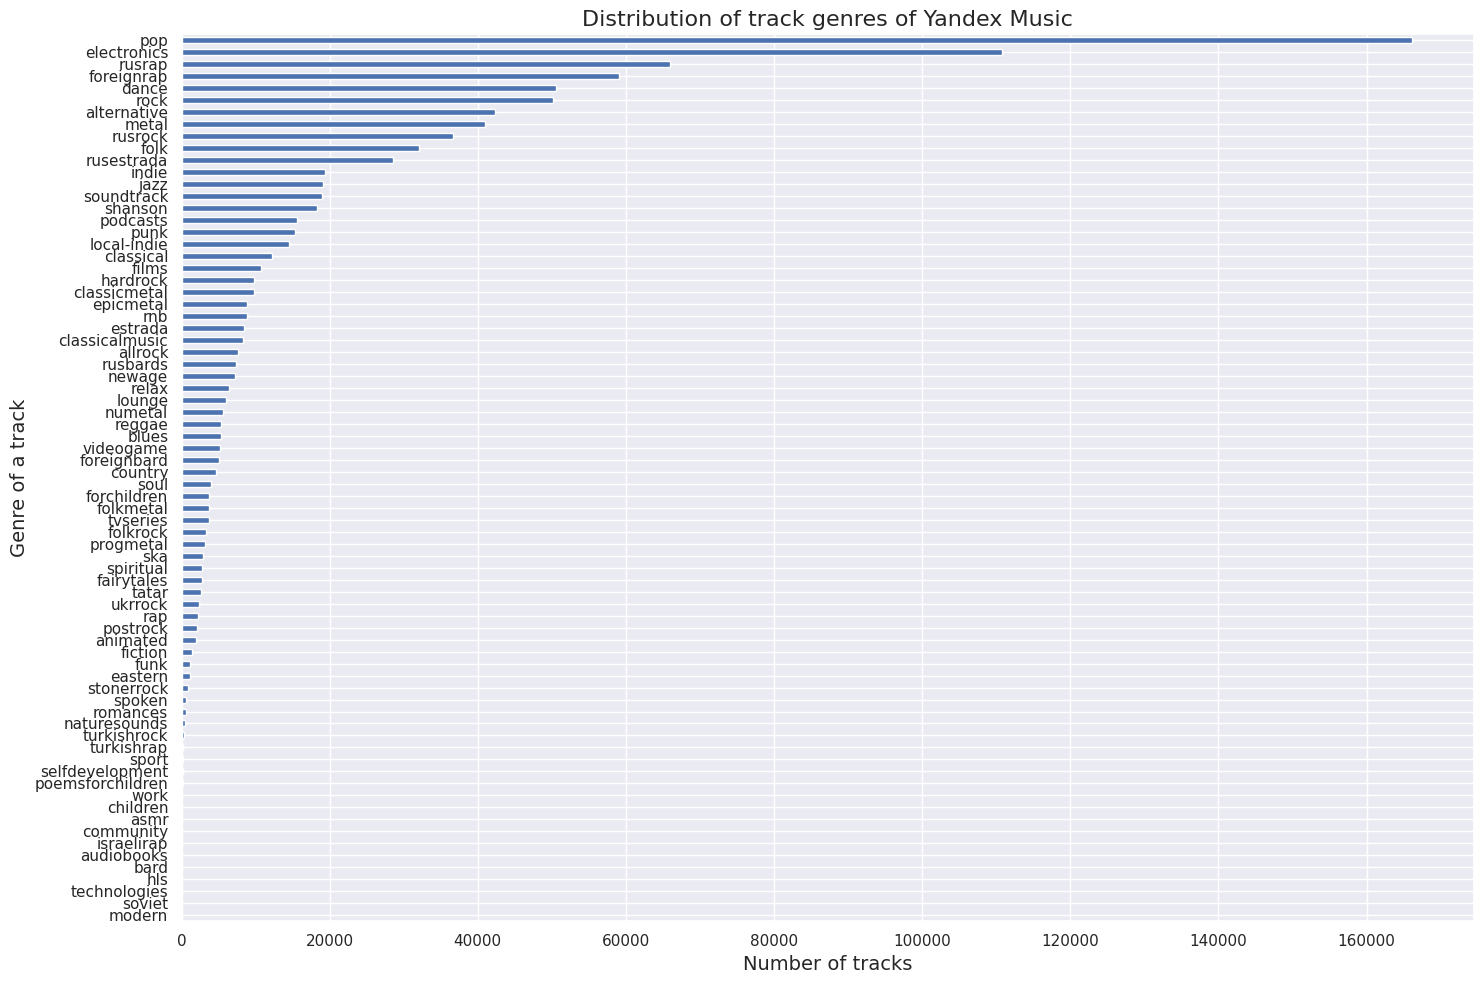

In [29]:
plt.figure(figsize=(15, 10))
items.genre.value_counts().sort_values().plot(kind="barh")
plt.ylabel("Genre of a track", fontsize=14)
plt.xlabel("Number of tracks", fontsize=14)
plt.title("Distribution of track genres of Yandex Music", fontsize=16)
plt.tight_layout()

Видим, что наибольшие доли музыкальных треков в данных приходятся на треки жанров `pop`, `electronic` и `rusrap`. Посмотрим на общую информацию о данных о треках, при этом фокусируясь на объеме памяти, который занимает датафрейм:

In [30]:
items.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Index: 1000000 entries, 0 to 6765309
Data columns (total 5 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   track_id  1000000 non-null  int64 
 1   track     1000000 non-null  object
 2   artist    984631 non-null   object
 3   album     999982 non-null   object
 4   genre     996306 non-null   object
dtypes: int64(1), object(4)
memory usage: 311.1 MB


In [31]:
items.track_id.min(), items.track_id.max()

(26, 101521819)

Мы можем слегка сократить размер данного датафрейма, сделав конвертацию типов данных. Известно, что максимальное значение, которое может содержать тип `int32` составляет порядка двух миллиардов, в регион которого укладывается максимальное значение идентификатора трека, так что можем поменять тип колонки `track_id` с `int64` на `int32`:

In [32]:
items["track_id"] = items["track_id"].astype("int32")

In [33]:
items.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Index: 1000000 entries, 0 to 6765309
Data columns (total 5 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   track_id  1000000 non-null  int32 
 1   track     1000000 non-null  object
 2   artist    984631 non-null   object
 3   album     999982 non-null   object
 4   genre     996306 non-null   object
dtypes: int32(1), object(4)
memory usage: 307.3 MB


In [34]:
items.head()

,track_id,track,artist,album,genre
0,26,Complimentary Me,Elizabeth & the Catapult,Taller Children,pop
4,38,Momma's Boy,Elizabeth & the Catapult,Taller Children,pop
8,135,Atticus,Noisettes,Wild Young Hearts,pop
11,136,24 Hours,Noisettes,Wild Young Hearts,pop
14,138,Don't Upset The Rhythm (Go Baby Go),Noisettes,Wild Young Hearts,pop


## Events

Теперь мы может перейти к рассмотрению данных о взаимодействиях пользователей с музыкальными треками. Рассмотрим данные:

In [35]:
events.info()

<class 'pandas.core.frame.DataFrame'>
Index: 222629898 entries, 0 to 291
Data columns (total 4 columns):
 #   Column      Dtype         
---  ------      -----         
 0   user_id     int32         
 1   track_id    int32         
 2   track_seq   int16         
 3   started_at  datetime64[ns]
dtypes: datetime64[ns](1), int16(1), int32(2)
memory usage: 5.4 GB


В данных присутствует около 222 млн различных действий, которые делали пользователи с треками (в данном случае это прослушивание самого трека). 

In [36]:
events.head()

,user_id,track_id,track_seq,started_at
0,0,99262,1,2022-07-17
1,0,589498,2,2022-07-19
2,0,590262,3,2022-07-21
3,0,590303,4,2022-07-22
4,0,590692,5,2022-07-22


In [37]:
print("Number of unique users: {:,}".format(events.user_id.nunique()))
print("Number of unique tracks: {:,}".format(events.track_id.nunique()))

Number of unique users: 1,373,221
Number of unique tracks: 1,000,000


Во взаимодействиях присутствует больше миллиона уникальных пользователей и ровно миллион уникальных треков, что означает, что все треки из `items` были хотя бы раз воспроизведены пользователями. Удалим ненужную колонку `track_seq`:

In [38]:
events = events.drop("track_seq", axis=1)
events.head()

,user_id,track_id,started_at
0,0,99262,2022-07-17
1,0,589498,2022-07-19
2,0,590262,2022-07-21
3,0,590303,2022-07-22
4,0,590692,2022-07-22


In [39]:
events.info()

<class 'pandas.core.frame.DataFrame'>
Index: 222629898 entries, 0 to 291
Data columns (total 3 columns):
 #   Column      Dtype         
---  ------      -----         
 0   user_id     int32         
 1   track_id    int32         
 2   started_at  datetime64[ns]
dtypes: datetime64[ns](1), int32(2)
memory usage: 5.0 GB


# Выводы

Приведём выводы по первому знакомству с данными:
- есть ли с данными явные проблемы,
- какие корректирующие действия (в целом) были предприняты.

На данном этапе мы смогли загрузить данные о музыкальных треках и взаимодействиях пользователей с ними и немного начать разбираться с тем, что они собой представляют. 

Во-первых, мы определили, что формат данных, который у нас был в данных о музыкальных треках, не является удобным для продолжения дальнейшей работы, что было поправлено путем дробления списков (указанных как значения в данных) по идентификатору трека. 

Во-вторых, еще одна проблема относилась не столько к формату данных, а к тому, что работа с датафреймом, в который включено все подряд, будет проблематична. Это касалось данных каталога, в который были загружены все данные о названиях треков, их исполнителях, жанрах и альбомах. Мы раздробили данный датафрейм на несколько суб-датафреймов, каждый из которых содержит информацию отдельно о названиях треков, исполнителях, альбомах и жанрах. Данная процедура оказалась полезной на следующем этапе слияния датафреймов, что нам дало один датафрейм `items`, где содержится вся информация о музыкальных треков в удобном формате.

В-третьих, в результате дробления списков у нас появилось большое количество дубликатов конкретного трека. Для того чтобы иметь возможность уникально идентифицировать каждый трек, был выбран только первый дубликат трека.

# === ЭТАП 2 ===

# EDA

Как мы видели ранее, в данных о взаимодействиях присутствует более 220 млн записей, что может оказаться проблемой с точки зрения памяти: проведение операций с таким датафреймом (не говоря уже о мерже других таблиц с ним) может привести к *kernel crash* ввиду превышения объема доступной оперативной памяти.

К счастью, мы можем получить выводы из исследовательского анализа и на основе выборки. В данном случае (в целях экономии *RAM*) возьмем случайные 25% наблюдений из `events` (при этом для возможности воспроизведения результатов откалибруем генератор случайных чисел с указанным в начале тетрадки `RANDOM_STATE`):

In [40]:
%%time
events_sample = events.sample(frac=0.25, random_state=RANDOM_STATE)
events_sample.head()

CPU times: user 11 s, sys: 666 ms, total: 11.7 s
Wall time: 11.6 s


,user_id,track_id,started_at
130,844258,3581309,2022-06-05
433,1091434,14937363,2022-06-29
526,73981,48591660,2022-09-26
9,78605,732405,2022-09-14
1202,1273064,40339506,2022-08-24


In [41]:
print("Number of unique users: {:,}".format(events_sample.user_id.nunique()))
print("Number of unique tracks: {:,}".format(events_sample.track_id.nunique()))
print("Number of events: {:,}".format(events_sample.shape[0]))

Number of unique users: 1,365,137
Number of unique tracks: 950,986
Number of events: 55,657,474


Мы видим, что даже взяв 25% данных мы сохранили большую часть информации о уникальных пользователях, однако при этом уменьшив размер данных с 220 до 55 млн. Число треков также приуменьшилось, но не слишком сильно.

Примержим к выборке информацию о названии трека и его жанре, что нам в дальнейшем понадобится:

In [42]:
events_sample = events_sample.merge(
    items[["track_id", "track", "genre"]],
    on="track_id",
    how="left",
)
events_sample.head()

,user_id,track_id,started_at,track,genre
0,844258,3581309,2022-06-05,Somebody That I Used To Know,pop
1,1091434,14937363,2022-06-29,The Monster,foreignrap
2,73981,48591660,2022-09-26,Шар,pop
3,78605,732405,2022-09-14,ХОЧЕШЬ?,rusrock
4,1273064,40339506,2022-08-24,Компромисс,rusrock


## Распределение количества прослушанных треков

Чтобы посмотреть на распределения количества прослушиваний, нужно построить график. У нас довольно большое количество треков, что будет очень нагружено выглядеть на графике. Как один из вариантов визуализации, можно сначала сгруппировать прослушивания по месяцам, а затем увидеть, как это число изменяется по месяцам. Для начала создадим маппинг номера к названию месяца, что понадобится после для графика.

In [43]:
id2month_mapping = {i: name for i, name in zip(range(12), calendar.month_name[1:])}
id2month_mapping

{0: 'January',
 1: 'February',
 2: 'March',
 3: 'April',
 4: 'May',
 5: 'June',
 6: 'July',
 7: 'August',
 8: 'September',
 9: 'October',
 10: 'November',
 11: 'December'}

Поскольку колонка `started_at` является типом `datetime` мы можем легко вытащить из нее порядковый номер месяца:

In [44]:
events_sample["month"] = events_sample["started_at"].dt.month
events_sample.head()

,user_id,track_id,started_at,track,genre,month
0,844258,3581309,2022-06-05,Somebody That I Used To Know,pop,6
1,1091434,14937363,2022-06-29,The Monster,foreignrap,6
2,73981,48591660,2022-09-26,Шар,pop,9
3,78605,732405,2022-09-14,ХОЧЕШЬ?,rusrock,9
4,1273064,40339506,2022-08-24,Компромисс,rusrock,8


Теперь мы можем сгруппировать данные по месяцам с расчетом числа прослушивания и использовать созданный ранее маппинг, что наложить на ось X названия месяцев для наглядности:

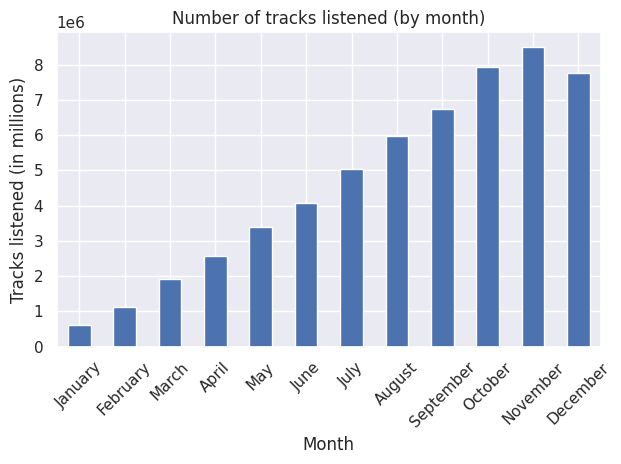

In [45]:
events_sample \
            .groupby("month")["track"] \
            .count() \
            .sort_index() \
            .plot(kind="bar")

plt.xlabel("Month")
plt.ylabel("Tracks listened (in millions)")
plt.title("Number of tracks listened (by month)")
plt.xticks(list(id2month_mapping.keys()), list(id2month_mapping.values()), rotation=45)
plt.tight_layout()
plt.show()

## Наиболее популярные треки

Рассчитаем топ-30 наиболее популярных треков:

In [46]:
events_sample.track_id \
            .value_counts() \
            .head(30) \
            .reset_index() \
            .merge(
                items[["track_id", "track", "artist"]],
                on="track_id",
                how="left",
            )[["track_id", "track", "artist", "count"]].set_index("track_id")

,track,artist,count
track_id,,,
53404,Smells Like Teen Spirit,Nirvana,27596
33311009,Believer,Imagine Dragons,26830
178529,Numb,Linkin Park,25543
35505245,I Got Love,Miyagi & Эндшпиль,24684
65851540,Юность,Dabro,21665
24692821,Way Down We Go,KALEO,21587
32947997,Shape of You,Ed Sheeran,21530
795836,Shape Of My Heart,Sting,21487
51241318,In The End,Tommee Profitt,21457


## Наиболее популярные жанры

Посмотрим на топ-30 наиболее популярных жанров:

In [47]:
events_sample.genre.value_counts().head(30)

genre
pop               13873850
rusrap             6327969
electronics        4672913
dance              3849000
rusrock            3290821
foreignrap         2951954
rock               2588872
alternative        2486226
metal              1600655
indie              1364048
rusestrada         1221573
local-indie        1017882
punk                885731
folk                851817
numetal             559733
shanson             553822
soundtrack          547633
films               524561
hardrock            514213
rnb                 481071
classicmetal        476886
jazz                416389
estrada             356269
epicmetal           316098
classicalmusic      314966
classical           295505
allrock             294781
foreignbard         274326
ukrrock             194016
folkrock            189807
Name: count, dtype: int64

## Треки, которые никто не прослушал

Чтобы понять, какие треки никто не слушал в данной выборке, мы можем отсеять идентификаторы треков, которые есть в `events_sample`, из `items` и посмотреть на оставшиеся:

In [48]:
items_track_ids = set(items.track_id.values.tolist())
events_track_ids = set(events_sample.track_id.values.tolist())

no_listens_ids = list(items_track_ids - events_track_ids)

print("Number of tracks not listened to: {:,}".format(len(no_listens_ids)))
print("Share: {:.2%}".format(len(no_listens_ids) / items.shape[0]))

Number of tracks not listened to: 49,014
Share: 4.90%


In [49]:
assert len(events_track_ids) + len(no_listens_ids) == items.shape[0]

In [50]:
items[items.track_id.isin(no_listens_ids)].sample(10, random_state=RANDOM_STATE)

,track_id,track,artist,album,genre
5120396,38363244,Trap Life,Trap,Trap,foreignrap
5595246,49364277,Motivasyon,Ben Fero,ORMAN KANUNLARI,turkishrap
4313055,25427236,Волшебница,Центр,Легенды Москвы,rusrock
6053380,61394657,Set Me Free,Desib-L,Set Me Free,electronics
4350583,25764755,Money and Run,UNKLE,Global Underground #41: James Lavelle Presents...,electronics
4360437,25891460,Remembering,Omega,The Beaty Sixties,rock
5478335,45397998,Elephant March,Wooli,Elephant March,electronics
4938314,35757780,"Страсти по Матфею, Тайная вечеря: Един от вас ...","Московский Синодальный хор, Владимир Федосеев,...",Митрополит Иларион: Музыка для оркестра и хора,classical
4476292,28345010,This Boy,The Beatles,Anthology 1,rock
5654642,51186002,"Русско- турецкие войны в программе ""Виват Исто...",NaN,"Виват, история!",podcasts


Заметим здесь, что мы смогли найти около 50 тыс. непрослушанных треков по причине того, что взяли выборку вместо полного набора данных. Как мы видели ранее, с данных о взаимодействиях присутствовало ровно 1 млн уникальных треков, то есть все треки были прослушаны хотя бы один раз.

# Преобразование данных

## Items

Преобразуем данные в формат, более пригодный для дальнейшего использования в расчётах рекомендаций. Для начала ресетнем индекс `items`:

In [51]:
items.head()

,track_id,track,artist,album,genre
0,26,Complimentary Me,Elizabeth & the Catapult,Taller Children,pop
4,38,Momma's Boy,Elizabeth & the Catapult,Taller Children,pop
8,135,Atticus,Noisettes,Wild Young Hearts,pop
11,136,24 Hours,Noisettes,Wild Young Hearts,pop
14,138,Don't Upset The Rhythm (Go Baby Go),Noisettes,Wild Young Hearts,pop


In [52]:
items = items.reset_index(drop=True)
items.head()

,track_id,track,artist,album,genre
0,26,Complimentary Me,Elizabeth & the Catapult,Taller Children,pop
1,38,Momma's Boy,Elizabeth & the Catapult,Taller Children,pop
2,135,Atticus,Noisettes,Wild Young Hearts,pop
3,136,24 Hours,Noisettes,Wild Young Hearts,pop
4,138,Don't Upset The Rhythm (Go Baby Go),Noisettes,Wild Young Hearts,pop


Для удобства дальнейшей работы мы можем перекодировать идентификаторы треков:

In [53]:
item_encoder = LabelEncoder()
item_encoder.fit(items["track_id"])
items["track_id_encoded"] = item_encoder.transform(items["track_id"])
items.head()

,track_id,track,artist,album,genre,track_id_encoded
0,26,Complimentary Me,Elizabeth & the Catapult,Taller Children,pop,0
1,38,Momma's Boy,Elizabeth & the Catapult,Taller Children,pop,1
2,135,Atticus,Noisettes,Wild Young Hearts,pop,2
3,136,24 Hours,Noisettes,Wild Young Hearts,pop,3
4,138,Don't Upset The Rhythm (Go Baby Go),Noisettes,Wild Young Hearts,pop,4


Сохраним кодировщик идентификаторов треков в отдельном файле:

In [54]:
try:
    with open("encoders/item_encoder.pkl", "wb") as fd:
        joblib.dump(item_encoder, fd)
except FileNotFoundError:
    with open("item_encoder.pkl", "wb") as fd:
        joblib.dump(item_encoder, fd)

Можем также сделать приведение типов для уменьшения объема занимаемой памяти:

In [55]:
items.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 6 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   track_id          1000000 non-null  int32 
 1   track             1000000 non-null  object
 2   artist            984631 non-null   object
 3   album             999982 non-null   object
 4   genre             996306 non-null   object
 5   track_id_encoded  1000000 non-null  int64 
dtypes: int32(1), int64(1), object(4)
memory usage: 307.3 MB


In [56]:
items["track_id_encoded"] = items["track_id_encoded"].astype("int32")

In [57]:
items.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 6 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   track_id          1000000 non-null  int32 
 1   track             1000000 non-null  object
 2   artist            984631 non-null   object
 3   album             999982 non-null   object
 4   genre             996306 non-null   object
 5   track_id_encoded  1000000 non-null  int32 
dtypes: int32(2), object(4)
memory usage: 303.5 MB


## Events

Как было упомянуто ранее, будет проблематично работать с полным набором событий. Ранее мы рассматривали случайные 25% наблюдений из `events`, однако такой подход отсеивает некоторые события отдельных пользователей, что может повлиять на рекомендации. В данном случае возьмем не 25% данных, а именно 25% пользователей, чтобы мы смогли иметь все события для таких пользователей.

In [58]:
events_user_ids = events.user_id.unique()
events_user_ids

array([      0,       1,       2, ..., 1374580, 1374581, 1374582],
      dtype=int32)

In [59]:
users_share = 0.25
num_users = int(users_share * len(events_user_ids))
print("Number of new unique users: {:,}".format(num_users))

Number of new unique users: 343,305


In [60]:
np.random.seed(RANDOM_STATE)
events_user_ids_new = np.random.choice(events_user_ids, size=num_users)
events_user_ids_new

array([ 122068,  671804,  132054, ..., 1264082, 1169057,  732620],
      dtype=int32)

In [61]:
events = events[events.user_id.isin(events_user_ids_new)]
print("Number of events: {:,}".format(events.shape[0]))

Number of events: 49,395,087


In [62]:
events.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49395087 entries, 0 to 23
Data columns (total 3 columns):
 #   Column      Dtype         
---  ------      -----         
 0   user_id     int32         
 1   track_id    int32         
 2   started_at  datetime64[ns]
dtypes: datetime64[ns](1), int32(2)
memory usage: 1.1 GB


In [63]:
events.isna().sum()

user_id       0
track_id      0
started_at    0
dtype: int64

In [64]:
events.head()

,user_id,track_id,started_at
0,4,966,2022-03-29
1,4,4094,2022-03-29
2,4,9760,2022-03-29
3,4,9769,2022-03-31
4,4,18392,2022-04-01


Поступим таким же образом и перекодируем идентификаторы пользователей для удобства, а для треков используем уже обученный кодировщик треков:

In [65]:
%%time
user_encoder = LabelEncoder()
user_encoder.fit(events["user_id"])
events["user_id_encoded"] = user_encoder.transform(events["user_id"])
events["track_id_encoded"] = item_encoder.transform(events["track_id"])
events.head()

CPU times: user 11.1 s, sys: 758 ms, total: 11.9 s
Wall time: 11.9 s


,user_id,track_id,started_at,user_id_encoded,track_id_encoded
0,4,966,2022-03-29,0,93
1,4,4094,2022-03-29,0,881
2,4,9760,2022-03-29,0,1962
3,4,9769,2022-03-31,0,1966
4,4,18392,2022-04-01,0,3361


Сохраним кодировщик идентификаторов пользователей:

In [66]:
try:
    with open("encoders/user_encoder.pkl", "wb") as fd:
        joblib.dump(user_encoder, fd)
except FileNotFoundError:
    with open("user_encoder.pkl", "wb") as fd:
        joblib.dump(user_encoder, fd)

# Сохранение данных

Сохраним данные в двух файлах локально в папке `data` и в персональном S3-бакете по пути `recsys/data/`:
- `items.parquet` — данные о музыкальных треках,
- `events.parquet` — все данные о взаимодействиях (расчет на 25% случайных пользователей).

In [67]:
try:
    items.to_parquet("data/items.parquet")
    events.to_parquet("data/events.parquet")
except OSError:
    items.to_parquet("items.parquet")
    events.to_parquet("events.parquet")

# Очистка памяти

Здесь, может понадобится очистка памяти для высвобождения ресурсов для выполнения кода ниже. 

Приведите соответствующие код, комментарии, например:
- код для удаление более ненужных переменных,
- комментарий, что следует перезапустить kernel, выполнить такие-то начальные секции и продолжить с этапа 3.

**NOTE:** *Чтобы не мучиться удалять все переменные, для продолжения здесь необходимо перезапустить kernel и выполнить самую первую ячейку с импортами.*

# === ЭТАП 3 ===

# Загрузка данных

Загрузим кодировщики и сохраненные на предыдущем этапе данные.

In [2]:
try:
    items = pd.read_parquet("data/items.parquet")
except FileNotFoundError:
    items = pd.read_parquet("items.parquet")
items.sample(5, random_state=RANDOM_STATE)

,track_id,track,artist,album,genre,track_id_encoded
987231,95229664,Have Yourself A Merry Little Christmas,Billy Porter,Have Yourself A Merry Little Christmas,pop,987231
79954,700056,"Баллада о том, кто недожил (Прерванный полёт)",Владимир Высоцкий,Баллады к кинофильму «Бегство мистера Мак-Кинли»,rusbards,79954
567130,39019190,Осторожно,Группа «ГРЕЙС»,Верю и люблю,shanson,567130
500891,34625231,In The Air,Raven & Kreyn,In The Air,electronics,500891
55399,518436,Take It In,Hot Chip,One Life Stand,electronics,55399


In [3]:
try:
    events = pd.read_parquet("data/events.parquet")
except FileNotFoundError:
    events = pd.read_parquet("events.parquet")
events.sample(5, random_state=RANDOM_STATE)

,user_id,track_id,started_at,user_id_encoded,track_id_encoded
381,25406,20712541,2022-07-25,5626,319486
275,1251371,26405349,2022-08-31,276753,390789
21,790745,33290410,2022-12-05,174607,483320
560,388831,17562805,2022-07-18,85925,277908
7,867911,366707,2022-08-23,191746,43612


In [4]:
try:
    with open("encoders/user_encoder.pkl", "rb") as fd:
        user_encoder = joblib.load(fd)
except FileNotFoundError:
    with open("user_encoder.pkl", "rb") as fd:
        user_encoder = joblib.load(fd)

In [5]:
try:
    with open("encoders/item_encoder.pkl", "rb") as fd:
        item_encoder = joblib.load(fd)
except FileNotFoundError:
    with open("item_encoder.pkl", "rb") as fd:
        item_encoder = joblib.load(fd)

# Разбиение данных

Перед тем как разбить данные на тренировочную и тестовую выборки, необходимо придумать какой-то аналог рейтингу, ведь без него не будет возможно построить рекомендации. В качестве замены мы можем использовать нормализированные числа прослушиваний треков. Иными словами, прослушивания будут служить своеобразным рейтингом популярности треков у пользователей, а нормализация делается, чтобы привести трек к более понятному виду (где *1.0* будет у самого популярного трека).

In [6]:
# Computing track popularity rating
track_popularity = events.groupby("track_id_encoded")["user_id_encoded"].count()
track_popularity /= track_popularity.max()
track_popularity = track_popularity.reset_index()
track_popularity = track_popularity.rename(
    columns={
        "user_id_encoded": "tracks_played"
    }
)
track_popularity

,track_id_encoded,tracks_played
0,1,0.000082
1,2,0.000367
2,3,0.000163
3,4,0.000245
4,5,0.000163
...,...,...
936071,999995,0.000082
936072,999996,0.000653
936073,999997,0.000122
936074,999998,0.000082


Добавим рейтинг к данным о взаимодействиях:

In [7]:
events = events.merge(
    track_popularity,
    on="track_id_encoded",
    how="left"
)
events.head()

,user_id,track_id,started_at,user_id_encoded,track_id_encoded,tracks_played
0,4,966,2022-03-29,0,93,0.019545
1,4,4094,2022-03-29,0,881,0.117227
2,4,9760,2022-03-29,0,1962,0.013628
3,4,9769,2022-03-31,0,1966,0.343561
4,4,18392,2022-04-01,0,3361,0.064918


Теперь мы можем разделить данные:

In [8]:
train_test_global_time_split_date = pd.to_datetime("2022-12-16")

train_test_global_time_split_idx = events["started_at"] < train_test_global_time_split_date
events_train = events[train_test_global_time_split_idx].copy()
events_test = events[~train_test_global_time_split_idx].copy()

print("Train set events number: {:,}".format(events_train.shape[0]))
print("Test set events number: {:,}".format(events_test.shape[0]))

Train set events number: 46,309,577
Test set events number: 3,085,510


Дополнительно можем посмотреть на число уникальных пользователей на трейне и тесте, а также на число общих и холодных пользователей:

In [9]:
users_train = events_train["user_id_encoded"].drop_duplicates().tolist()
users_test = events_test["user_id_encoded"].drop_duplicates().tolist()

common_users = set(users_train) & set(users_test)
cold_users = (set(users_train) | set(users_test)) - set(users_train)

print("Number of unique train users: {:,}".format(len(users_train)))
print("Number of unique test users: {:,}".format(len(users_test)))
print("Number of common users: {:,}".format(len(common_users)))
print("Number of cold users: {:,}".format(len(cold_users)))

Number of unique train users: 297,170
Number of unique test users: 173,677
Number of common users: 166,913
Number of cold users: 6,764


# Топ популярных

Рассчитаем рекомендации как топ популярных (возьмем топ 100).

In [10]:
top_popular = events_train.track_id \
            .value_counts() \
            .head(100) \
            .reset_index() \
            .rename(
                columns={
                    "count": "tracks_played",
                }
            ) \
            .merge(
                items[["track_id", "track", "artist"]],
                on="track_id",
                how="left",
            )[["track_id", "track", "artist", "tracks_played"]]
top_popular["track_id_encoded"] = item_encoder.transform(top_popular["track_id"])
top_popular

,track_id,track,artist,tracks_played,track_id_encoded
0,53404,Smells Like Teen Spirit,Nirvana,24274,9098
1,33311009,Believer,Imagine Dragons,22382,483876
2,178529,Numb,Linkin Park,22198,26665
3,35505245,I Got Love,Miyagi & Эндшпиль,21120,512157
4,24692821,Way Down We Go,KALEO,18719,368072
...,...,...,...,...,...
95,75944934,Astronaut In The Ocean,Masked Wolf,10550,904055
96,75642961,Венера-Юпитер,Ваня Дмитриенко,10541,902660
97,68348389,Minor,Miyagi & Andy Panda,10516,848373
98,68562711,Сияй,Ramil',10474,849895


In [11]:
try:
    top_popular.to_parquet("data/top_popular.parquet")
except OSError:
    top_popular.to_parquet("top_popular.parquet")

# Персональные

Рассчитаем персональные рекомендации. Сначала создадим разреженную матрицу *user-item* со значениями рейтинга популярности как значения.

In [12]:
user_item_matrix_train = scipy.sparse.csr_matrix(
    (
    events_train["tracks_played"],
    (events_train["user_id_encoded"], events_train["track_id_encoded"])
    ),
    dtype=np.int8
)
user_item_matrix_train

<Compressed Sparse Row sparse matrix of dtype 'int8'
	with 46309577 stored elements and shape (303934, 1000000)>

Видим, что в нашей матрице 303934 строки (пользователи) и 1000000 колонок (треки). Теперь мы можем запустить алгоритм ALS:

In [13]:
als_params = {
    "factors": 50,
    "iterations": 100,
    "regularization": 0.05,
    "random_state": RANDOM_STATE,
}

als_model = AlternatingLeastSquares(**als_params)
als_model.fit(user_item_matrix_train)

/home/mle-user/mle_projects/final_projects/mle-project-sprint-4-v001/.venv_recsys/lib/python3.10/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 4 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()
100%|██████████████████████████████████████████████████████████████████████████| 100/100 [11:11<00:00,  6.71s/it]


Теперь когда у нас есть обученная модель, ее можно использовать для генерации рекомендаций. Следующая ячейка рекомендует каждому пользователю по 10 треков (число 10 было выбрано ради более быстрого исполнения кода). В данной спецификации (25% пользователей + 10 рекомендаций), даже используя меньший объем наблюдений и `N=10`, код исполняется также довольно небыстро. 

**Note:** *Следующая ячейка генерирует рекомендации всем пользователям около 10 минут.*

In [14]:
%%time
# Retrieving all encoded user identifiers
user_ids_encoded = range(len(user_encoder.classes_))

# Getting recommendations for all users
als_recommendations = als_model.recommend(
    user_ids_encoded, 
    user_item_matrix_train[user_ids_encoded], 
    filter_already_liked_items=False, 
    N=10,
)

CPU times: user 30min 3s, sys: 11min 37s, total: 41min 41s
Wall time: 10min 36s


Теперь приведем результат метода `recommend` в более понятный вид:

In [15]:
# Separating identifiers and ALS-scores
track_ids_encoded = als_recommendations[0]
als_scores = als_recommendations[1]

# Building a DataFrame of recommendations
als_recommendations = pd.DataFrame({
    "user_id_encoded": user_ids_encoded,
    "track_id_encoded": track_ids_encoded.tolist(), 
    "score": als_scores.tolist(),
})
als_recommendations = als_recommendations.explode(["track_id_encoded", "score"], ignore_index=True)

# Types conversions
als_recommendations["track_id_encoded"] = als_recommendations["track_id_encoded"].astype("int")
als_recommendations["score"] = als_recommendations["score"].astype("float")

# Retrieving the original identifiers
als_recommendations["user_id"] = user_encoder.inverse_transform(als_recommendations["user_id_encoded"])
als_recommendations["track_id"] = item_encoder.inverse_transform(als_recommendations["track_id_encoded"])
als_recommendations = als_recommendations.drop(columns=["user_id_encoded", "track_id_encoded"])

# Rearranging columns
als_recommendations = als_recommendations[["user_id", "track_id", "score"]]

In [16]:
als_recommendations

,user_id,track_id,score
0,4,53404,1.788324e-13
1,4,50834580,4.845297e-20
2,4,81848875,4.298855e-20
3,4,32182642,4.107725e-20
4,4,49961817,3.987751e-20
...,...,...,...
3039335,1374579,88476064,7.005857e-20
3039336,1374579,43716993,6.977971e-20
3039337,1374579,628320,6.969311e-20
3039338,1374579,29611476,6.623787e-20


То есть теперь для каждого пользователя у нас есть по 10 рекомендаций, например:

In [17]:
als_recommendations.query("user_id == 4").merge(items, on="track_id", how="left")

,user_id,track_id,score,track,artist,album,genre,track_id_encoded
0,4,53404,1.788324e-13,Smells Like Teen Spirit,Nirvana,Nevermind,alternative,9098
1,4,50834580,4.845297e-20,Девочка-война,HammAli & Navai,Девочка-война,rusrap,692312
2,4,81848875,4.298855e-20,Федерико Феллини,Galibri & Mavik,Федерико Феллини,pop,935913
3,4,32182642,4.107725e-20,Лирика,Filatov & Karas,Лирика,dance,461481
4,4,49961817,3.987751e-20,Грустный дэнс,Artik & Asti,Грустный дэнс,pop,682662
5,4,54837415,3.808033e-20,Пчеловод,RASA,Пчеловод,pop,732487
6,4,48591588,3.772809e-20,Моя игра,Баста,БАСТА 1,rusrap,671818
7,4,1695498,3.713159e-20,Что такое осень,ДДТ,Актриса Весна,rusrock,110532
8,4,72055319,3.498404e-20,Снова я напиваюсь,SLAVA MARLOW,Снова я напиваюсь,rusrap,876846
9,4,68938482,3.366973e-20,Не пускайте танцевать,Timran,Не пускайте танцевать,dance,852574


In [18]:
als_recommendations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3039340 entries, 0 to 3039339
Data columns (total 3 columns):
 #   Column    Dtype  
---  ------    -----  
 0   user_id   int32  
 1   track_id  int32  
 2   score     float64
dtypes: float64(1), int32(2)
memory usage: 46.4 MB


Визуально можем также взглянуть как последние действия пользователя соотносятся с сгенерированными рекомендациями:

In [19]:
# Choosing a random user_id
test_user_id = events_train.user_id.drop_duplicates().tolist()[100]

# Displaying the last 10 events for the user
last_10_events = events_train \
        .query("user_id == @test_user_id") \
        .tail(10) \
        .merge(
            items, 
            on="track_id", 
            how="left",
        )[["user_id", "track_id", "track", "artist", "album", "genre"]]
print(f"Last 10 events for 'user_id={test_user_id}'")
display(last_10_events)

# Displaying the recommendations
user_recs = als_recommendations \
            .query("user_id == @test_user_id") \
            .merge(items, on="track_id", how="left").drop(["score", "track_id_encoded"], axis=1)
print(f"Recommendations for 'user_id={test_user_id}'")
display(user_recs)

Last 10 events for 'user_id=448'


,user_id,track_id,track,artist,album,genre
0,448,81160369,Словно Ветер В Степи,G63 BEATS.,Словно Ветер В Степи,electronics
1,448,82212331,Восемь,Лилу45,Восемь,local-indie
2,448,86052167,"каждый, кто делал тебе больно","забей, лерочка","каждый, кто делал тебе больно",local-indie
3,448,86324491,Asereje,Dj Quba,Asereje,dance
4,448,86925158,My Mother Told Me,Cullen Vance,My Mother Told Me,folk
5,448,88322889,Drive Forever,kingmichaelbeats,Drive Forever,rap
6,448,89428582,Samedy,Канцлер ГИ,Вуду Tales,rusrock
7,448,89977237,У России три пути,GSPD,У России три пути,dance
8,448,91786354,Logobi Type Beat,ParoxingBeatz,Logobi Type Beat,electronics
9,448,94130071,Слава роду,HELVEGEN,Один из нас,folk


Recommendations for 'user_id=448'


,user_id,track_id,track,artist,album,genre
0,448,43526313,Детство,Rauf & Faik,Я люблю тебя,pop
1,448,6024130,Дыхание,Nautilus Pompilius,Крылья,rusrock
2,448,2786766,We Are Young,Fun.,We Are Young,alternative
3,448,58515506,Увезите меня на Дип-хаус,GAYAZOV$ BROTHER$,Увезите меня на Дип-хаус,pop
4,448,47627256,Cradles,Sub Urban,Cradles,electronics
5,448,73376988,Ягода малинка,ХАБИБ,Ягода малинка,pop
6,448,48592141,Положение,Скриптонит,Уроборос: Улица 36,rusrap
7,448,31105795,Молодые ветра,7Б,Новая коллекция. Лучшие песни,rusrock
8,448,52380688,Любимка,NILETTO,Любимка,pop
9,448,42727040,Hislerim,Serhat Durmus,Hislerim,electronics


Сохраним персональные рекомендации:

In [20]:
try:
    als_recommendations.to_parquet("data/personal_als.parquet")
except OSError:
    als_recommendations.to_parquet("personal_als.parquet")

# Похожие

Рассчитаем похожие треки, они позже пригодятся для онлайн-рекомендаций. Ввиду того что, что треков очень много в данных, выполнение следующей ячейки может занять довольно много времени. Поэтому чтобы не ждать очень долго, рассчитаем только для части треков (рассчитаем 5 наиболее схожих треков, то есть ставим `N=6`, поскольку трек сам с собой в любом случае будет схож):

In [21]:
%%time
train_track_ids_encoded = range(len(item_encoder.classes_))[:50000]

similar_items = als_model.similar_items(train_track_ids_encoded, N=6)

CPU times: user 5min 39s, sys: 2min 54s, total: 8min 34s
Wall time: 2min 12s


Как мы делали ранее, приведем все к более понятному виду:

In [22]:
# Separating identifiers from similarity scores
sim_item_item_ids_enc = similar_items[0]
sim_item_scores = similar_items[1]

# Building a DataFrame of track similarities
similar_items = pd.DataFrame({
    "track_id_encoded": train_track_ids_encoded,
    "sim_track_id_encoded": sim_item_item_ids_enc.tolist(), 
    "score": sim_item_scores.tolist()})
similar_items = similar_items.explode(["sim_track_id_encoded", "score"], ignore_index=True)

# Converting types
similar_items["sim_track_id_encoded"] = similar_items["sim_track_id_encoded"].astype("int64")
similar_items["score"] = similar_items["score"].astype("float")

# Retrieving original track identifiers
similar_items["track_id_1"] = item_encoder.inverse_transform(similar_items["track_id_encoded"])
similar_items["track_id_2"] = item_encoder.inverse_transform(similar_items["sim_track_id_encoded"])
similar_items = similar_items.drop(columns=["track_id_encoded", "sim_track_id_encoded"])

# Filtering out tracks similar to themselves
similar_items = similar_items.query("track_id_1 != track_id_2")

similar_items = similar_items[["track_id_1", "track_id_2", "score"]]
similar_items

,track_id_1,track_id_2,score
0,26,139,0.000000
1,26,138,0.000000
2,26,136,0.000000
3,26,135,0.000000
4,26,38,0.000000
...,...,...,...
299995,446684,53726952,0.757322
299996,446684,29028731,0.755143
299997,446684,39178075,0.734521
299998,446684,38184093,0.722108


Можно также визуально посмотреть на схожие треки для какого-то конкретного трека:

In [23]:
trackid = events_train.track_id.drop_duplicates().tolist()[11]
tr = items.query("track_id == @trackid")
display(tr)

k = similar_items.query("track_id_1 == @trackid").merge(items, left_on="track_id_2", right_on="track_id")
display(k)

,track_id,track,artist,album,genre,track_id_encoded
5862,33475,Live Wire,Mötley Crüe,Red White & Crue,classicmetal,5862


,track_id_1,track_id_2,score,track_id,track,artist,album,genre,track_id_encoded
0,33475,44103459,0.823887,44103459,Мёртв внутри,White Punk,Вампиръ,rusrock,632935
1,33475,26244420,0.803185,26244420,Don't You (Forget About Me),Simple Minds,Once Upon A Time,rock,388894
2,33475,10367866,0.799439,10367866,Smoking While We Drive,Snoop Dogg,Smoking While We Drive,foreignrap,222994
3,33475,64254244,0.792232,64254244,Price Right,Biicla,No Place,dance,815525
4,33475,2166389,0.789514,2166389,Любовь-комета,Наталия Власова,Сборник,pop,119544


In [24]:
similar_items.info()

<class 'pandas.core.frame.DataFrame'>
Index: 252910 entries, 0 to 299999
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   track_id_1  252910 non-null  int32  
 1   track_id_2  252910 non-null  int32  
 2   score       252910 non-null  float64
dtypes: float64(1), int32(2)
memory usage: 5.8 MB


In [25]:
try:
    similar_items.to_parquet("data/similar.parquet")
except OSError:
    similar_items.to_parquet("similar.parquet")

# Построение признаков

Построим три признака, можно больше, для ранжирующей модели.

## Training data

Для начала разобьем тестовые данные на еще две выборки:

* `events_labels` => для расчета таргетов
* `events_test_2` => отложенная выборка для расчетов метрик

Ранее мы делили данные по дате 16.12.2023. В данном случае возьмем дату неделю спустя:

In [26]:
split_date_for_labels = pd.to_datetime("2022-12-23")

split_date_for_labels_idx = events_test["started_at"] < split_date_for_labels
events_labels = events_test[split_date_for_labels_idx].copy()
events_test_2 = events_test[~split_date_for_labels_idx].copy()

print(events_labels.shape, events_test_2.shape)

(1641041, 6) (1444469, 6)


Теперь можно разметить данные, где прослушивание трека пользователем будем отмечать как положительный класс (единица), а в противном случае - негативный класс (ноль). Таким образом, мы сможем построить модель, предсказывающую вероятность взаимодействия пользователя с объектом.

In [27]:
# Initially setting all objects to positive class
events_labels["target"] = 1

# Adding target to the recommendations
candidates = als_recommendations.merge(
    events_labels[["user_id", "track_id", "target"]],
    on=["user_id", "track_id"],
    how="left",
)

# Replacing NaNs with zero (negative class)
candidates["target"] = candidates["target"].fillna(0).astype("int")

Таким методом мы объединили рассчитанные рекомендации с историей взаимодействия пользователей с объектами, где образовавшиеся пустые значения (то есть на месте объектов, с которыми пользователь не взаимодействовал) заменили нулями. Посмотрим на баланс классов:

In [28]:
candidates.target.value_counts(normalize=True)

target
0    0.999024
1    0.000976
Name: proportion, dtype: float64

Наблюдаем чрезвычайно сильный дисбаланс классов. Модель не сможет научиться хорошо распознавать классы. Возьмем подвыборки: сначала возьмем только тех пользователей, у которых есть хотя бы один положительный таргет, а затем для каждого пользователя оставим только 4 негативных примера:

In [29]:
%%time
# Keeping users with at least 1 positive target
candidates = candidates.groupby("user_id").filter(lambda x: x["target"].sum() > 0)

# Keeping users with only 4 negative examples
candidates_for_train = pd.concat([
    candidates.query("target == 1"),
    candidates.query("target == 0") \
        .groupby("user_id") \
        .apply(lambda x: x.sample(4, random_state=RANDOM_STATE))
])

# Deleting `candidates` DataFrame
del candidates
gc.collect()

CPU times: user 21.8 s, sys: 537 ms, total: 22.3 s
Wall time: 21.9 s


0

Посмотрим на дисбаланс:

In [30]:
candidates_for_train.target.value_counts(normalize=True)

target
0    0.792384
1    0.207616
Name: proportion, dtype: float64

Ситуация стала слегка лучше, ресетнем индекс и посмотрим на данные:

In [31]:
candidates_for_train = candidates_for_train.reset_index(drop=True)
display(candidates_for_train.head())
display(candidates_for_train.info())

,user_id,track_id,score,target
0,464,66322065,5.039634e-20,1
1,503,43942453,6.802856e-20,1
2,645,60292250,5.851431e-20,1
3,1209,60292250,5.641042e-21,1
4,2538,10776533,1.375346e-19,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14286 entries, 0 to 14285
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   14286 non-null  int32  
 1   track_id  14286 non-null  int32  
 2   score     14286 non-null  float64
 3   target    14286 non-null  int64  
dtypes: float64(1), int32(2), int64(1)
memory usage: 335.0 KB


None

### Generating features

Следующим шагом начнем создавать признаки, ведь только лишь на основе скора ALS вряд ли построишь надежную модель. 

Одним из признаков используем жанр трека:

In [32]:
# Adding genre to the training data
candidates_for_train = candidates_for_train.merge(
    items[["track_id", "genre"]],
    on="track_id",
    how="left"
)
candidates_for_train.head()

,user_id,track_id,score,target,genre
0,464,66322065,5.039634e-20,1,pop
1,503,43942453,6.802856e-20,1,local-indie
2,645,60292250,5.851431e-20,1,rnb
3,1209,60292250,5.641042e-21,1,rnb
4,2538,10776533,1.375346e-19,1,rock


Данную фичу конечно нельзя будет напрямую использовать в модели. Вначале нужно будет ее закодировать, но к счастью модели градиентного бустинга *catboost* могут работать с такими признаками напрямую, что будет показано позже.

Следующим признаком будет доля конкретного жанра в тренировочных взаимодействиях:

In [33]:
genre_shares = events_train \
                .merge(
                    items[["track_id", "genre"]], 
                    on="track_id", 
                    how="left",
                ).groupby("genre")["track_id"].count()
genre_shares /= genre_shares.sum()
genre_shares = genre_shares.reset_index().rename(columns={"track_id": "genre_share"})
genre_shares.sort_values(by="genre_share", ascending=False)

,genre,genre_share
42,pop,2.459024e-01
54,rusrap,1.124665e-01
15,electronics,8.442541e-02
13,dance,6.793198e-02
55,rusrock,6.012076e-02
...,...,...
31,israelirap,3.435821e-06
5,bard,2.485028e-06
29,hls,2.463419e-06
4,audiobooks,8.427487e-07


Добавим фичу к данным:

In [34]:
candidates_for_train = candidates_for_train.merge(
    genre_shares,
    on="genre",
    how="left"
)
candidates_for_train.head()

,user_id,track_id,score,target,genre,genre_share
0,464,66322065,5.039634e-20,1,pop,0.245902
1,503,43942453,6.802856e-20,1,local-indie,0.018300
2,645,60292250,5.851431e-20,1,rnb,0.008675
3,1209,60292250,5.641042e-21,1,rnb,0.008675
4,2538,10776533,1.375346e-19,1,rock,0.047187


In [35]:
candidates_for_train = candidates_for_train.rename(
    columns={
        "score": "als_score"
    }
)
candidates_for_train.head()

,user_id,track_id,als_score,target,genre,genre_share
0,464,66322065,5.039634e-20,1,pop,0.245902
1,503,43942453,6.802856e-20,1,local-indie,0.018300
2,645,60292250,5.851431e-20,1,rnb,0.008675
3,1209,60292250,5.641042e-21,1,rnb,0.008675
4,2538,10776533,1.375346e-19,1,rock,0.047187


In [36]:
candidates_for_train.isna().sum()

user_id        0
track_id       0
als_score      0
target         0
genre          0
genre_share    0
dtype: int64

In [37]:
candidates_for_train.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14286 entries, 0 to 14285
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   user_id      14286 non-null  int32  
 1   track_id     14286 non-null  int32  
 2   als_score    14286 non-null  float64
 3   target       14286 non-null  int64  
 4   genre        14286 non-null  object 
 5   genre_share  14286 non-null  float64
dtypes: float64(2), int32(2), int64(1), object(1)
memory usage: 1.3 MB


## Inference data

Для того чтобы считать метрики нам необходимо иметь тестовые рекомендации. Предполагается что в таком случае события из `events_labels` уже стали частью тренировочного набора:

In [38]:
events_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 46309577 entries, 0 to 49395086
Data columns (total 6 columns):
 #   Column            Dtype         
---  ------            -----         
 0   user_id           int32         
 1   track_id          int32         
 2   started_at        datetime64[ns]
 3   user_id_encoded   int64         
 4   track_id_encoded  int64         
 5   tracks_played     float64       
dtypes: datetime64[ns](1), float64(1), int32(2), int64(2)
memory usage: 2.1 GB


In [39]:
inference_data = pd.concat([events_train, events_labels])
inference_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47950618 entries, 0 to 49395062
Data columns (total 7 columns):
 #   Column            Dtype         
---  ------            -----         
 0   user_id           int32         
 1   track_id          int32         
 2   started_at        datetime64[ns]
 3   user_id_encoded   int64         
 4   track_id_encoded  int64         
 5   tracks_played     float64       
 6   target            float64       
dtypes: datetime64[ns](1), float64(2), int32(2), int64(2)
memory usage: 2.5 GB


Обучим новую ALS-модель и повторим все преобразования заново:

In [40]:
user_item_matrix_inference = scipy.sparse.csr_matrix(
    (
    inference_data["tracks_played"],
    (inference_data["user_id_encoded"], inference_data["track_id_encoded"])
    ),
    dtype=np.int8
)
user_item_matrix_inference

<Compressed Sparse Row sparse matrix of dtype 'int8'
	with 47950618 stored elements and shape (303934, 1000000)>

In [41]:
als_model_inference = AlternatingLeastSquares(**als_params)
als_model_inference.fit(user_item_matrix_inference)

100%|██████████████████████████████████████████████████████████████████████████| 100/100 [11:22<00:00,  6.83s/it]


In [42]:
%%time
user_ids_encoded = range(len(user_encoder.classes_))

als_recommendations_inference = als_model_inference.recommend(
    user_ids_encoded, 
    user_item_matrix_inference[user_ids_encoded], 
    filter_already_liked_items=False, 
    N=10,
)

CPU times: user 29min 56s, sys: 11min 43s, total: 41min 39s
Wall time: 10min 36s


In [43]:
track_ids_encoded = als_recommendations_inference[0]
als_scores = als_recommendations_inference[1]

als_recommendations_inference = pd.DataFrame({
    "user_id_encoded": user_ids_encoded,
    "track_id_encoded": track_ids_encoded.tolist(), 
    "score": als_scores.tolist(),
})
als_recommendations_inference = als_recommendations_inference.explode(
    ["track_id_encoded", "score"], ignore_index=True
)

als_recommendations_inference["track_id_encoded"] = als_recommendations_inference["track_id_encoded"].astype("int")
als_recommendations_inference["score"] = als_recommendations_inference["score"].astype("float")

als_recommendations_inference["user_id"] = user_encoder.inverse_transform(
    als_recommendations_inference["user_id_encoded"]
)
als_recommendations_inference["track_id"] = item_encoder.inverse_transform(
    als_recommendations_inference["track_id_encoded"]
)
als_recommendations_inference = als_recommendations_inference.drop(
    columns=["user_id_encoded", "track_id_encoded"]
)

als_recommendations_inference = als_recommendations_inference[["user_id", "track_id", "score"]]
als_recommendations_inference.head(10)

,user_id,track_id,score
0,4,53404,2.470839e-12
1,4,23559960,4.552044e-20
2,4,1710811,3.458561e-20
3,4,81848875,3.347138e-20
4,4,60292250,3.272448e-20
5,4,6679078,3.106566e-20
6,4,17198795,3.031365e-20
7,4,78194999,2.905115e-20
8,4,67538121,2.766610e-20
9,4,70619465,2.749917e-20


In [44]:
try:
    als_recommendations_inference.to_parquet("data/personal_als_inference.parquet")
except OSError:
    als_recommendations_inference.to_parquet("personal_als_inference.parquet")

Для экономии ресурсов включим только пользователей из `events_test_2`:

In [45]:
candidates_to_rank = als_recommendations_inference[
    als_recommendations_inference.user_id.isin(events_test_2.user_id.drop_duplicates())
]
candidates_to_rank.head()

,user_id,track_id,score
0,4,53404,2.470839e-12
1,4,23559960,4.552044e-20
2,4,1710811,3.458561e-20
3,4,81848875,3.347138e-20
4,4,60292250,3.272448e-20


### Adding features

Добавим созданные признаки к данным для инференса:

In [46]:
candidates_to_rank = candidates_to_rank.merge(
    items[["track_id", "genre"]],
    on="track_id",
    how="left"
)
candidates_to_rank.head()

,user_id,track_id,score,genre
0,4,53404,2.470839e-12,alternative
1,4,23559960,4.552044e-20,indie
2,4,1710811,3.458561e-20,rock
3,4,81848875,3.347138e-20,pop
4,4,60292250,3.272448e-20,rnb


In [47]:
candidates_to_rank = candidates_to_rank.merge(
    genre_shares,
    on="genre",
    how="left"
)
candidates_to_rank.head()

,user_id,track_id,score,genre,genre_share
0,4,53404,2.470839e-12,alternative,0.045580
1,4,23559960,4.552044e-20,indie,0.024834
2,4,1710811,3.458561e-20,rock,0.047187
3,4,81848875,3.347138e-20,pop,0.245902
4,4,60292250,3.272448e-20,rnb,0.008675


In [48]:
candidates_to_rank.isna().sum()

user_id        0
track_id       0
score          0
genre          0
genre_share    0
dtype: int64

In [49]:
candidates_to_rank = candidates_to_rank.rename(
    columns={
        "score": "als_score"
    }
)
candidates_to_rank.head()

,user_id,track_id,als_score,genre,genre_share
0,4,53404,2.470839e-12,alternative,0.045580
1,4,23559960,4.552044e-20,indie,0.024834
2,4,1710811,3.458561e-20,rock,0.047187
3,4,81848875,3.347138e-20,pop,0.245902
4,4,60292250,3.272448e-20,rnb,0.008675


In [50]:
candidates_to_rank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1339780 entries, 0 to 1339779
Data columns (total 5 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   user_id      1339780 non-null  int32  
 1   track_id     1339780 non-null  int32  
 2   als_score    1339780 non-null  float64
 3   genre        1339780 non-null  object 
 4   genre_share  1339780 non-null  float64
dtypes: float64(2), int32(2), object(1)
memory usage: 40.9+ MB


Поскольку в дальнейшем для расчета метрик мы будет использовать разные варианты датафрейма `candidates_to_rank` (для ранжирования персональных рекомендаций и итоговых), сохраним текущее состояние датафрейма, чтобы можно было начать с одной точки: 

In [51]:
candidates_to_rank_personal = candidates_to_rank.copy()
candidates_to_rank_final = candidates_to_rank.copy()

del candidates_to_rank
gc.collect()

0

# Ранжирование рекомендаций

Построим ранжирующую модель, чтобы сделать рекомендации более точными. Отранжируем рекомендации.

## Персональные ALS

Для начала обучим модель на данных без использования топа популярных. Будем использовать стандартные настройки классификатора градиентного бустинга, где добавим несколько новых:

* `cat_features` => Поскольку фича `genre` представляет собой категориальный нечисловой признак, воспользуемся встроенным параметром библиотеки `catboost` для работы с таким типом колонок, который укажем в структуре `Pool`;
* `one_hot_max_size` => Включение данного параметра с высоким значением позволит принудительно кодировать единственную категориальную фичу при помощи *OHE*, которая имеет около 30 категорий жанров; 
* `auto_class_weights` => Присутствующий дисбаланс классов модель будет устранять автоматически при помощи расчета весов для каждого класса.  

In [52]:
# Specifying features and target
features = ["als_score", "genre", "genre_share"]
cat_features = ["genre"]
target = ["target"]

# Pooling training data
train_data = Pool(
    data=candidates_for_train[features],
    label=candidates_for_train[target],
    cat_features=cat_features,
)

# Specifying model parameters
catboost_params = {
    "iterations": 1700,
    "learning_rate": 0.09,
    "depth": 3,
    "verbose": 100,
    "loss_function": "Logloss",
    "one_hot_max_size": 100,
    "auto_class_weights": "Balanced",
    "random_seed": RANDOM_STATE,
}
model = CatBoostClassifier(**catboost_params)

# Launching training
model.fit(train_data)

0:	learn: 0.6803862	total: 54.2ms	remaining: 1m 32s
100:	learn: 0.6092438	total: 279ms	remaining: 4.42s
200:	learn: 0.6027145	total: 512ms	remaining: 3.81s
300:	learn: 0.5979328	total: 746ms	remaining: 3.47s
400:	learn: 0.5943741	total: 978ms	remaining: 3.17s
500:	learn: 0.5913316	total: 1.21s	remaining: 2.9s
600:	learn: 0.5889015	total: 1.45s	remaining: 2.65s
700:	learn: 0.5868833	total: 1.68s	remaining: 2.4s
800:	learn: 0.5847407	total: 1.92s	remaining: 2.15s
900:	learn: 0.5826944	total: 2.14s	remaining: 1.9s
1000:	learn: 0.5811877	total: 2.38s	remaining: 1.66s
1100:	learn: 0.5796127	total: 2.6s	remaining: 1.42s
1200:	learn: 0.5781294	total: 2.83s	remaining: 1.18s
1300:	learn: 0.5770091	total: 3.06s	remaining: 938ms
1400:	learn: 0.5757182	total: 3.28s	remaining: 701ms
1500:	learn: 0.5746807	total: 3.51s	remaining: 465ms
1600:	learn: 0.5735558	total: 3.74s	remaining: 231ms
1699:	learn: 0.5724701	total: 3.96s	remaining: 0us


Теперь можем воспользоваться моделью для инференса, то есть предскажем вероятность того, что пользователь будет взаимодействовать с объектом:

In [53]:
# Predicting interaction probabilities
inf_data = Pool(data=candidates_to_rank_personal[features], cat_features=cat_features)
predictions = model.predict_proba(inf_data)
candidates_to_rank_personal["cb_score"] = predictions[:, 1]

# Sorting the DataFrame to create rankings
candidates_to_rank_personal = candidates_to_rank_personal.sort_values(
    by=["user_id", "cb_score"], ascending=[True, False]
)

# Ranking recommendations
candidates_to_rank_personal["rank"] = candidates_to_rank_personal.groupby("user_id").cumcount() + 1

In [54]:
candidates_to_rank_personal.head()

,user_id,track_id,als_score,genre,genre_share,cb_score,rank
4,4,60292250,3.272448e-20,rnb,0.008675,0.815677,1
3,4,81848875,3.347138e-20,pop,0.245902,0.623609,2
6,4,17198795,3.031365e-20,pop,0.245902,0.615930,3
9,4,70619465,2.749917e-20,pop,0.245902,0.614665,4
7,4,78194999,2.905115e-20,rusrap,0.112467,0.573623,5


Можем также посмотреть на то, какие признаки оказались важными для предсказаний с точки зрения модели:

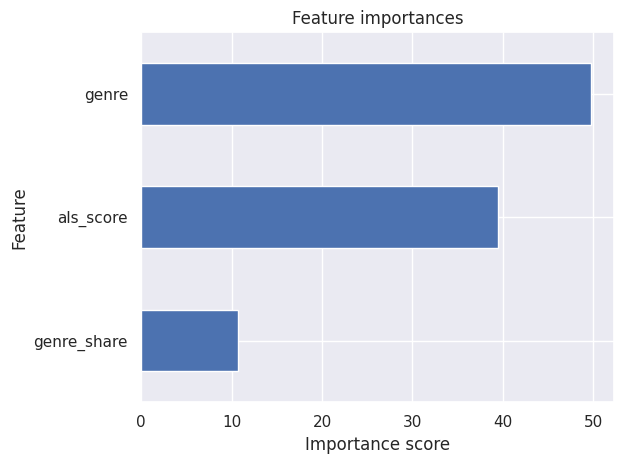

In [55]:
fi = pd.Series(
    model.feature_importances_,
    index=features,
    name="fi_personal_recs",
).sort_values()

fi.plot(kind="barh")
plt.title("Feature importances")
plt.ylabel("Feature")
plt.xlabel("Importance score")
plt.tight_layout()
plt.show()

## Итоговые рекомендации

Для расчета итоговых рекомендаций добавим новую фичу к данным, а именно число прослушиваний. Сначала рассчитаем число прослушиваний треков для каждого из них:

In [56]:
popular = events_train.track_id \
            .value_counts() \
            .reset_index() \
            .merge(
                items[["track_id", "track", "artist"]],
                on="track_id",
                how="left",
            )[["track_id", "track", "artist", "count"]]
popular

,track_id,track,artist,count
0,53404,Smells Like Teen Spirit,Nirvana,24274
1,33311009,Believer,Imagine Dragons,22382
2,178529,Numb,Linkin Park,22198
3,35505245,I Got Love,Miyagi & Эндшпиль,21120
4,24692821,Way Down We Go,KALEO,18719
...,...,...,...,...
919736,436749,Taste The Red Hands,Dead Poetic,1
919737,61690343,Mémoire,Maes,1
919738,83778917,Я тебя закопаю под снег,prvrln,1
919739,88718967,IMMORTAL,JUNIOR FERRARI,1


Теперь смержим эту таблицу с тренировочными и тестовыми рекомендациями.

In [57]:
candidates_for_train = candidates_for_train.merge(
    popular[["track_id", "count"]],
    on="track_id",
    how="left",
)
candidates_for_train.head()

,user_id,track_id,als_score,target,genre,genre_share,count
0,464,66322065,5.039634e-20,1,pop,0.245902,11314
1,503,43942453,6.802856e-20,1,local-indie,0.018300,15098
2,645,60292250,5.851431e-20,1,rnb,0.008675,16624
3,1209,60292250,5.641042e-21,1,rnb,0.008675,16624
4,2538,10776533,1.375346e-19,1,rock,0.047187,8683


In [58]:
candidates_to_rank_final = candidates_to_rank_final.merge(
    popular[["track_id", "count"]],
    on="track_id",
    how="left",
)
candidates_to_rank_final.head()

,user_id,track_id,als_score,genre,genre_share,count
0,4,53404,2.470839e-12,alternative,0.045580,24274.0
1,4,23559960,4.552044e-20,indie,0.024834,15384.0
2,4,1710811,3.458561e-20,rock,0.047187,12729.0
3,4,81848875,3.347138e-20,pop,0.245902,11436.0
4,4,60292250,3.272448e-20,rnb,0.008675,16624.0


In [59]:
candidates_to_rank_final.isna().sum()

user_id           0
track_id          0
als_score         0
genre             0
genre_share       0
count          2622
dtype: int64

Запустим обучение новой модели:

In [60]:
features.append("count")
target = ["target"]

train_data = Pool(
    data=candidates_for_train[features],
    label=candidates_for_train[target],
    cat_features=cat_features,
)

model = CatBoostClassifier(**catboost_params)

model.fit(train_data)

0:	learn: 0.6798919	total: 2.81ms	remaining: 4.78s
100:	learn: 0.5927914	total: 222ms	remaining: 3.51s
200:	learn: 0.5733386	total: 443ms	remaining: 3.3s
300:	learn: 0.5621892	total: 665ms	remaining: 3.09s
400:	learn: 0.5534316	total: 898ms	remaining: 2.91s
500:	learn: 0.5467932	total: 1.13s	remaining: 2.71s
600:	learn: 0.5421107	total: 1.37s	remaining: 2.5s
700:	learn: 0.5367795	total: 1.6s	remaining: 2.28s
800:	learn: 0.5322435	total: 1.83s	remaining: 2.06s
900:	learn: 0.5284104	total: 2.07s	remaining: 1.83s
1000:	learn: 0.5237072	total: 2.3s	remaining: 1.61s
1100:	learn: 0.5204380	total: 2.54s	remaining: 1.38s
1200:	learn: 0.5176297	total: 2.77s	remaining: 1.15s
1300:	learn: 0.5147901	total: 3s	remaining: 920ms
1400:	learn: 0.5118787	total: 3.23s	remaining: 689ms
1500:	learn: 0.5092981	total: 3.46s	remaining: 458ms
1600:	learn: 0.5069761	total: 3.69s	remaining: 228ms
1699:	learn: 0.5041308	total: 3.92s	remaining: 0us


In [61]:
inf_data = Pool(data=candidates_to_rank_final[features], cat_features=cat_features)
predictions = model.predict_proba(inf_data)

candidates_to_rank_final["cb_score"] = predictions[:, 1]

candidates_to_rank_final = candidates_to_rank_final.sort_values(
    by=["user_id", "cb_score"], ascending=[True, False]
)
candidates_to_rank_final["rank"] = candidates_to_rank_final.groupby("user_id").cumcount() + 1

In [62]:
candidates_to_rank_final.head()

,user_id,track_id,als_score,genre,genre_share,count,cb_score,rank
3,4,81848875,3.347138e-20,pop,0.245902,11436.0,0.832675,1
4,4,60292250,3.272448e-20,rnb,0.008675,16624.0,0.818144,2
9,4,70619465,2.749917e-20,pop,0.245902,10130.0,0.726640,3
7,4,78194999,2.905115e-20,rusrap,0.112467,7192.0,0.671969,4
8,4,67538121,2.766610e-20,rusrap,0.112467,6769.0,0.493854,5


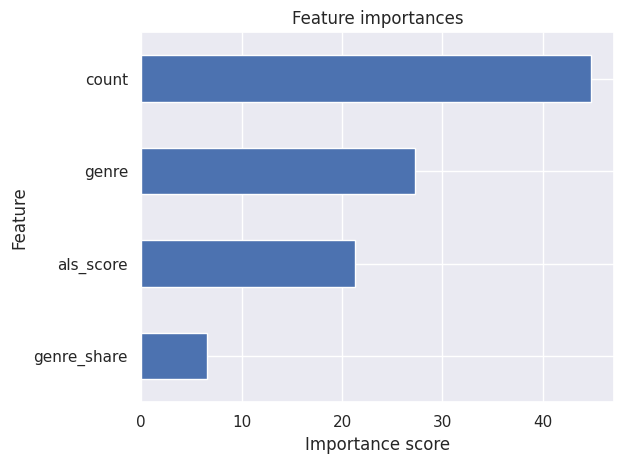

In [63]:
fi = pd.Series(
    model.feature_importances_,
    index=features,
    name="fi_final_recs",
).sort_values()

fi.plot(kind="barh")
plt.title("Feature importances")
plt.ylabel("Feature")
plt.xlabel("Importance score")
plt.tight_layout()
plt.show()

Получившиеся рекомендации, которые были отранжированы и представляют собой итоговые рекомендации, который сохраним в `final_recommendations`.

In [64]:
final_recommendations = candidates_to_rank_final.copy()

del candidates_to_rank_final
gc.collect()

6644

In [65]:
final_recommendations.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Index: 1339780 entries, 3 to 1339773
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   user_id      1339780 non-null  int32  
 1   track_id     1339780 non-null  int32  
 2   als_score    1339780 non-null  float64
 3   genre        1339780 non-null  object 
 4   genre_share  1339780 non-null  float64
 5   count        1337158 non-null  float64
 6   cb_score     1339780 non-null  float64
 7   rank         1339780 non-null  int64  
dtypes: float64(4), int32(2), int64(1), object(1)
memory usage: 151.4 MB


In [66]:
try:
    final_recommendations.to_parquet("data/recommendations.parquet")
except OSError:
    final_recommendations.to_parquet("recommendations.parquet")

# Оценка качества

Проверим оценку качества трёх типов рекомендаций: 

- топ популярных,
- персональных, полученных при помощи ALS,
- итоговых
  
по четырем метрикам: recall, precision, coverage, novelty.

## Топ популярных

Для топа популярных обучать модель нет необходимости. В данном случае возможно лишь рассчитать общий *recall*, который по сути говорит о том, сколько рекомендаций из топа попали во взаимодействия пользователей (рассмотрим здесь холодных).

In [67]:
events_cold = events[events.user_id.isin(cold_users)].drop("tracks_played", axis=1)
events_cold.info()

<class 'pandas.core.frame.DataFrame'>
Index: 244387 entries, 19859 to 10794098
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   user_id           244387 non-null  int32         
 1   track_id          244387 non-null  int32         
 2   started_at        244387 non-null  datetime64[ns]
 3   user_id_encoded   244387 non-null  int64         
 4   track_id_encoded  244387 non-null  int64         
dtypes: datetime64[ns](1), int32(2), int64(2)
memory usage: 9.3 MB


In [68]:
events_cold.head()

,user_id,track_id,started_at,user_id_encoded,track_id_encoded
19859,353,3735369,2022-04-04,81,152210
19860,353,5310285,2022-05-23,81,182512
19861,353,9439965,2022-05-23,81,212793
19862,353,17198143,2022-06-06,81,272412
19863,353,17326708,2022-06-25,81,275073


In [69]:
events_cold_top = events_cold.merge(
    top_popular[["track_id", "tracks_played"]],
    on="track_id",
    how="left",
)
events_cold_top.head()

,user_id,track_id,started_at,user_id_encoded,track_id_encoded,tracks_played
0,353,3735369,2022-04-04,81,152210,NaN
1,353,5310285,2022-05-23,81,182512,NaN
2,353,9439965,2022-05-23,81,212793,NaN
3,353,17198143,2022-06-06,81,272412,NaN
4,353,17326708,2022-06-25,81,275073,NaN


In [70]:
events_cold_top.isna().sum()

user_id                  0
track_id                 0
started_at               0
user_id_encoded          0
track_id_encoded         0
tracks_played       237256
dtype: int64

In [71]:
top_listened_share = events_cold_top \
                            .groupby("user_id")["tracks_played"] \
                            .apply(lambda x: x.notnull().mean())
top_listened_share

user_id
353       0.000000
786       0.016173
794       0.000000
883       0.033333
1115      0.043478
            ...   
302292    0.171875
302463    0.032258
302661    0.045455
302930    0.061069
303562    0.000000
Name: tracks_played, Length: 1487, dtype: float64

In [72]:
recall_gen = top_listened_share.mean()
print(f"Recall for top popular: {recall_gen:.5f}")

Recall for top popular: 0.05192


## Персональные ALS

### Recall / Precision

In [73]:
def process_events_recs_for_binary_metrics(events_train, events_test, recs, top_k=None):
    """Labels <user_id, track_id> pairs for common users with features:
    - gt => ground truth
    - pr => prediction
    top_k => using top-k recommendations for computation
    """
    
    events_test["gt"] = True
    common_users = set(events_test["user_id"]) & set(recs["user_id"])

    print(f"Common users: {len(common_users)}")
    
    events_for_common_users = events_test[events_test["user_id"].isin(common_users)].copy()
    recs_for_common_users = recs[recs["user_id"].isin(common_users)].copy()

    recs_for_common_users = recs_for_common_users.sort_values(["user_id", "score"], ascending=[True, False])

    events_for_common_users = events_for_common_users[events_for_common_users["track_id"].isin(
        events_train["track_id"].unique()
    )
    ]

    if top_k is not None:
        recs_for_common_users = recs_for_common_users.groupby("user_id").head(top_k)
    
    events_recs_common = events_for_common_users[["user_id", "track_id", "gt"]].merge(
        recs_for_common_users[["user_id", "track_id", "score"]], 
        on=["user_id", "track_id"], 
        how="outer",
    )    

    events_recs_common["gt"] = events_recs_common["gt"].fillna(False)
    events_recs_common["pr"] = ~events_recs_common["score"].isnull()
    
    events_recs_common["tp"] = events_recs_common["gt"] & events_recs_common["pr"]
    events_recs_common["fp"] = ~events_recs_common["gt"] & events_recs_common["pr"]
    events_recs_common["fn"] = events_recs_common["gt"] & ~events_recs_common["pr"]

    return events_recs_common

In [74]:
events_recs_for_binary_metric = process_events_recs_for_binary_metrics(
    inference_data,
    events_test_2,
    candidates_to_rank_personal.rename(columns={"cb_score": "score"}),
    top_k=5,
)

Common users: 133978


In [75]:
def compute_cls_metrics(events_recs_for_binary_metric):
    """Computes precision and recall."""
    
    groupper = events_recs_for_binary_metric.groupby("user_id")

    # Computing precision
    precision = groupper["tp"].sum()/(groupper["tp"].sum()+groupper["fp"].sum())
    precision = precision.fillna(0).mean()
    
    # Computing recall
    recall = groupper["tp"].sum()/(groupper["tp"].sum()+groupper["fn"].sum())
    recall = recall.fillna(0).mean()

    return precision, recall

In [76]:
precision_at_5_personal, recall_at_5_personal = compute_cls_metrics(events_recs_for_binary_metric)

print(f"Precision@5 = {precision_at_5_personal:.5f} ({precision_at_5_personal:.3%})")
print(f"Recall@5 = {recall_at_5_personal:.5f} ({recall_at_5_personal:.3%})")

Precision@5 = 0.00288 (0.288%)
Recall@5 = 0.00197 (0.197%)


### Coverage

In [77]:
coverage_personal = candidates_to_rank_personal.track_id.nunique() / items.shape[0]
print(f"Coverage = {coverage_personal} ({coverage_personal:.3%})")

Coverage = 0.00095 (0.095%)


### Novelty

In [78]:
events_train["seen"] = True

candidates_to_rank_personal = candidates_to_rank_personal.merge(
    events_train, 
    on=["user_id", "track_id"], 
    how="left"
)

candidates_to_rank_personal["seen"] = candidates_to_rank_personal["seen"].fillna(False).astype("bool")

In [79]:
candidates_to_rank_personal = candidates_to_rank_personal.sort_values(by="als_score", ascending=False)
candidates_to_rank_personal["rank"] = candidates_to_rank_personal.groupby("user_id").cumcount() + 1

In [80]:
novelty_at_5_personal = (1 - candidates_to_rank_personal.query("rank <= 5").groupby("user_id")["seen"].mean())
novelty_at_5_personal = novelty_at_5_personal.mean()

print(f"Novelty@5 = {novelty_at_5_personal:.4f}")

Novelty@5 = 0.9580


## Итоговые рекомендации

### Recall/Precision

In [81]:
events_recs_for_binary_metric = process_events_recs_for_binary_metrics(
    inference_data,
    events_test_2,
    final_recommendations.rename(columns={"cb_score": "score"}),
    top_k=5,
)

Common users: 133978


In [82]:
precision_at_5_final, recall_at_5_final = compute_cls_metrics(events_recs_for_binary_metric)

print(f"Precision@5 = {precision_at_5_final:.5f} ({precision_at_5_final:.3%})")
print(f"Recall@5 = {recall_at_5_final:.5f} ({recall_at_5_final:.3%})")

Precision@5 = 0.00338 (0.338%)
Recall@5 = 0.00241 (0.241%)


### Coverage

In [83]:
coverage_final = final_recommendations.track_id.nunique() / items.shape[0]
print(f"Coverage = {coverage_final} ({coverage_final:.3%})")

Coverage = 0.00095 (0.095%)


### Novelty

In [84]:
events_train["seen"] = True

final_recommendations = final_recommendations.merge(
    events_train, 
    on=["user_id", "track_id"], 
    how="left"
)

final_recommendations["seen"] = final_recommendations["seen"].fillna(False).astype("bool")

In [85]:
final_recommendations = final_recommendations.sort_values(by="als_score", ascending=False)
final_recommendations["rank"] = final_recommendations.groupby("user_id").cumcount() + 1

In [86]:
novelty_at_5_final = (1 - final_recommendations.query("rank <= 5").groupby("user_id")["seen"].mean())
novelty_at_5_final = novelty_at_5_final.mean()

print(f"Novelty@5 = {novelty_at_5_personal:.4f}")

Novelty@5 = 0.9580


# === Выводы, метрики ===

Основные выводы при работе над расчётом рекомендаций, рассчитанные метрики.

Соберем рассчитанные метрики в одной таблице:

In [87]:
top_popular_metrics = pd.Series([recall_gen], index=["recall_gen"], name="top_popular")

personal_als_metrics = pd.Series(
    [
        precision_at_5_personal, 
        recall_at_5_personal, 
        coverage_personal, 
        novelty_at_5_personal
    ], 
    index=["precision_at_5", "recall_at_5", "coverage", "novelty_at_5"],
    name="personal_als"
)

final_recs_metrics = pd.Series(
    [
        precision_at_5_final, 
        recall_at_5_final, 
        coverage_final, 
        novelty_at_5_final
    ], 
    index=["precision_at_5", "recall_at_5", "coverage", "novelty_at_5"],
    name="final_recs",
)

pd.concat([top_popular_metrics, personal_als_metrics, final_recs_metrics], axis=1)

,top_popular,personal_als,final_recs
recall_gen,0.051925,NaN,NaN
precision_at_5,NaN,0.002875,0.003375
recall_at_5,NaN,0.001967,0.002412
coverage,NaN,0.000950,0.000950
novelty_at_5,NaN,0.958026,0.958026


Видим, что привнесение числа прослушиваний как дополнительной фичи позволило немного увеличить качество по метрикам *precision* и *recall*. 

Если поглядеть на единственную метрику топа популярных, то можно заключить, что просто рекомендуя наиболее популярные треки можно более эффективнее угадывать предпочтения пользователя. Конечно мы не использовали весь предоставленный набор взаимодействий (25% пользователей), что возможно повлияло и привело к низким метрикам методов, основанных на ALS. 

Тем не менее такие методы позволяют рекомендовать треки, который пользователь ранее не видел (метрика *novelty* довольно высока). К тому же с другой стороны, рекомендуя случайные треки, тоже можно было бы добиться высоких значений *novelty*. 

Судя по низким метрикам *coverage*, заключим, что в рекомендациях представлена малая часть треков из общего набора в `items`. Тем не менее, возможно это и не настолько плохой результат, учитывая то, что пользователи не обязательно слушают много треков и не все им может быть интересно. Повлияло здесь еще и то, что ради экономии времени мы брали только топ-10 рекомендаций для расчета.